In [35]:
from collections import defaultdict
from typing import Tuple

# Symbolic Defaults by 'complexity' of expression
In this notebook we take a look at the results of running the script at its default settings, this means:
 - evaluation across all tasks
 - recording the pareto front of symbolic defaults after each search
 - evaluating in-sample and out-of-sample performance of those dynamic defaults, as well as some pre-defined ones
 
**note:** The console cut off results for the first few tasks, so I am rerunning those now.

In [60]:
with open('runs/pareto2.txt') as fh:
    lines = fh.readlines()

In [102]:
# saved because it's useful later, moreso than now.
first_definition = [i for i, line in enumerate(lines) if ':=' in line][0]

print("The predefined defaults are:")
for line in lines[first_definition:]:
    if ':=' in line:
        print(f" * {line[len('INFO:root:'):-1]}")

The predefined defaults are:
 * sklearn_scale := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
 * symbolic_v2 := make_tuple(m, add(mkd, mkd)))
 * const := make_tuple(812.267350, 0.001361)


In [92]:
benchmarks = ["const", "sklearn_scale", "symbolic_best", "symbolic_v2"]

In [62]:
task_starts = [i for i, line in enumerate(lines) if "INFO:root:START_TASK:" in line]
in_sample_starts = [i for i, line in enumerate(lines) if "INFO:root:Evaluating in sample:" in line]
out_sample_starts = [i for i, line in enumerate(lines) if "INFO:root:Evaluating out-of-sample:" in line]

For each task we will extract:
 - the number of generations optimization ran for (max=200)
 - max length expression
 - in and out of sample performance for length 1, 2 and 3 expression
 - 

In [63]:
def parse_evaluation_line(line) -> Tuple[str, int, float]:
    """ Parse an evaluation line, returning the expression or name, its 'length' and the score.
    
    e.g. INFO:root:[make_tuple(p, mkd)|0.8893]\n -> 'make_tuple(p, mkd)', 1, 0.8893 
    Length is 0 for benchmark problems.
    """
    start, pipe, end = line.find('['), line.find('|'), line.find(']')
    expression = line[start + 1 : pipe]
    expression_length = expression.count('(')
    return expression, expression_length, float(line[pipe + 1 : end])

For each task save the benchmark results, as well as the results of a random length 1, 2 and 3 solution if available.

In [117]:
tasks = [int(line[:-1].split(": ")[-1]) for line in lines if "INFO:root:START_TASK:" in line]
idx = pd.MultiIndex.from_product([tasks, ["in-sample", "out-sample"]], names=['task', 'sample-type'])
df = pd.DataFrame(index=idx, columns=["score-1","score-2", "score-3", *benchmarks], dtype=float)

In [118]:
expressions_by_length = defaultdict(list)
generations_by_task = {}

for task_start, in_start, out_start, next_task in zip(task_starts, in_sample_starts, out_sample_starts, task_starts[1:] + [first_definition]):
    # start line looks like: INFO:root:START_TASK: 29\n
    task = int(lines[task_start][:-1].split(": ")[-1])
    
    # Since the in-sample evaluation message follows directly after optimization is done, we use that to record
    # the number of generations. We account for the early stopping message if it did not run to 200 generations.
    ended_early = 0 if in_start - task_start == 201 else - 1
    generations_by_task[task] = in_start - (task_start + 1) - ended_early
    
    # Following the "INFO:root:Evaluating in sample:" message, symbolic default performance are printed
    # They are formatted as "INFO:root:[make_tuple(p, mkd)|0.8893]"
    # First is any number of best solutions from the pareto front. The last four are benchmark solutions.
    # It is possible that two equally good solutions are printed (i.e. same length and performance).    
    expr_in_task = set()
    for in_sample_evaluation in lines[in_start + 1 : out_start]:
        expr, length, score = parse_evaluation_line(in_sample_evaluation)
        # Pareto fronts may contain literal duplicates, so we filter those out manually.
        if expr not in expr_in_task:
            expressions_by_length[length].append(expr)
            expr_in_task.add(expr)
        
        if length !=0:
            if length < 4:
                # Only report one out-of-sample solution for each length (and all benchmarks), so overwrite is OK.
                df.loc[task, "in-sample"][f"score-{length}"] = score
        else:
            df.loc[task, "in-sample"][expr] = score
    
    for out_sample_evaluation in lines[out_start + 1 : next_task]:
        expr, length, score = parse_evaluation_line(out_sample_evaluation)   
        if length !=0:
            if length < 4:
                # Only report one out-of-sample solution for each length (and all benchmarks), so overwrite is OK.
                df.loc[task, "out-sample"][f"score-{length}"] = score
        else:
            df.loc[task, "out-sample"][expr] = score
    

In [119]:
for length, expressions in sorted(expressions_by_length.items()):
    m = max(set(expressions), key=expressions.count)
    print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")

 Found 424 expressions of length 0. Most frequent: const (106 times)
 Found  90 expressions of length 1. Most frequent: make_tuple(p, mkd) (90 times)
 Found  96 expressions of length 2. Most frequent: make_tuple(m, truediv(mkd, xvar)) (62 times)
 Found  73 expressions of length 3. Most frequent: make_tuple(truediv(m, mcp), truediv(mkd, xvar)) (10 times)
 Found  36 expressions of length 4. Most frequent: make_tuple(mul(truediv(m, add(mkd, mcp)), m), mkd) (1 times)
 Found  18 expressions of length 5. Most frequent: make_tuple(min(8.0, add(truediv(m, mcp), 0.4510853871213856)), truediv(mkd, xvar)) (1 times)
 Found  10 expressions of length 6. Most frequent: make_tuple(truediv(m, expit(0.6493408449339997)), truediv(truediv(mkd, xvar), max(0.7588938169572615, xvar))) (1 times)
 Found   5 expressions of length 7. Most frequent: make_tuple(truediv(sub(truediv(m, xvar), mcp), mul(mul(max(rc, mcp), xvar), xvar)), mkd) (1 times)
 Found   5 expressions of length 8. Most frequent: make_tuple(trued

"Found `N` expressions of length `L`" here means across all the tasks' pareto fronts `N` solutions have length `L`.
Pareto fronts may contain duplicate entries.

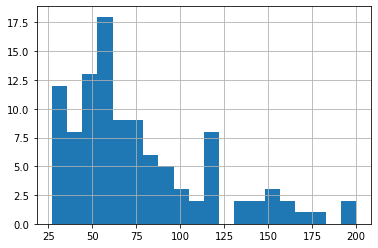

In [120]:
import pandas as pd
pd.Series(generations_by_task, name="generations").hist(bins=20)

Above plot shows the histogram of the number of generations across tasks (binsize=10).
Note that if something ran for less than 200 generations, it found its optimum 20 generations earlier and early stopping terminated search.

In [121]:
df

score-1  score-2  score-3   const  sklearn_scale  \
task   sample-type                                                     
3      in-sample     0.8896   0.9018      NaN  0.8608         0.8870   
       out-sample    0.9641   0.9132      NaN  0.9420         0.9193   
6      in-sample     0.8894   0.9011      NaN  0.8609         0.8865   
       out-sample    0.9893   0.9912      NaN  0.9355         0.9681   
11     in-sample     0.8902   0.9020      NaN  0.8612         0.8873   
...                     ...      ...      ...     ...            ...   
189928 out-sample    0.9249   0.9397      NaN  0.8361         0.8853   
190411 in-sample     0.8902   0.9018   0.9056  0.8613         0.8874   
       out-sample    0.9041   0.9153   0.9153  0.8884         0.8788   
190412 in-sample     0.8915   0.8928      NaN  0.8674         0.8914   
       out-sample    0.7625   0.7625      NaN  0.2500         0.4536   

                    symbolic_best  symbolic_v2  
task   sample-type                              
3      in-sample           0.8949       0.8855  
       out-sample          0.9816       0.8774  
6      in-sample           0.8948       0.8843  
       out-sample          0.9893       0.9958  
11     in-sample           0.8951       0.8852  
...                           ...          ...  
189928 out-sample          0.9782       0.8864  
190411 in-sample           0.8954       0.8854  
       out-sample          0.9301       0.8811  
190412 in-sample           0.8972       0.8883  
       out-sample          0.7339       0.5789  

[212 rows x 7 columns]

In [122]:
out_sample = df.index.map(lambda idx: idx[1] == "out-sample")
df.loc[out_sample]

,,score-1,score-2,score-3,const,sklearn_scale,symbolic_best,symbolic_v2
task,sample-type,,,,,,,
3,out-sample,0.9641,0.9132,NaN,0.9420,0.9193,0.9816,0.8774
6,out-sample,0.9893,0.9912,NaN,0.9355,0.9681,0.9893,0.9958
11,out-sample,0.9035,0.8982,NaN,0.8968,0.8807,0.9531,0.9050
12,out-sample,0.9990,0.9990,0.9990,0.9983,0.9925,0.9985,0.9958
14,out-sample,0.9960,0.9944,0.9944,0.9926,0.9647,0.9958,0.9867
...,...,...,...,...,...,...,...,...
189924,out-sample,0.6658,0.9854,0.9249,0.5543,0.7663,0.9862,0.5274
189927,out-sample,0.9457,0.9695,0.9714,0.9355,0.9692,0.9695,0.8911
189928,out-sample,0.9249,0.9397,NaN,0.8361,0.8853,0.9782,0.8864


In [123]:
df.loc[out_sample].idxmax(axis=1).value_counts()

score-1          29
symbolic_best    18
symbolic_v2      17
sklearn_scale    15
const            11
score-2          10
score-3           6
dtype: int64

In [124]:
in_sample = df.index.map(lambda idx: idx[1] == "in-sample")
df.loc[in_sample].idxmax(axis=1).value_counts()

score-3          46
score-2          39
symbolic_best    21
dtype: int64

In [125]:
df.loc[in_sample]

,,score-1,score-2,score-3,const,sklearn_scale,symbolic_best,symbolic_v2
task,sample-type,,,,,,,
3,in-sample,0.8896,0.9018,NaN,0.8608,0.8870,0.8949,0.8855
6,in-sample,0.8894,0.9011,NaN,0.8609,0.8865,0.8948,0.8843
11,in-sample,0.8902,0.9020,NaN,0.8612,0.8873,0.8951,0.8852
12,in-sample,0.8893,0.8935,0.8995,0.8603,0.8863,0.8947,0.8843
14,in-sample,0.8893,0.9011,0.9011,0.8603,0.8865,0.8947,0.8844
...,...,...,...,...,...,...,...,...
189924,in-sample,0.8924,0.9011,0.9013,0.8645,0.8884,0.8948,0.8888
189927,in-sample,0.8898,0.9000,0.9028,0.8609,0.8865,0.8950,0.8853
189928,in-sample,0.8900,0.9016,NaN,0.8618,0.8873,0.8949,0.8854
